Ref: 
https://www.tensorflow.org/guide/keras/custom_layers_and_models
https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit

https://tf.wiki/zh_hant/preface.html

https://github.com/maziarraissi/PINNs

## The ODE example

The ODE equation is:

$$\frac{d\phi}{dt}+(t+\frac{1+3t^2}{1+t+t^3})\phi=t^3+2t+t^2\frac{1+3t^2}{1+t+t^3}$$

With the following condition:
$$\phi(0) = 1\quad and \quad t \in [0,1]$$

The analytic solution is:
    
$$\phi(t) = \frac{e^{-t^2}/2}{1+t+t^3}$$

In [159]:
# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import time

print(tf.__version__)

2.3.1


# 1. Build model

## [Loss function](https://www.tensorflow.org/guide/keras/train_and_evaluate#custom_losses)

In [172]:
class ODE_Loss(tf.keras.losses.Loss):
    def __init__(self, regularization_factor=0.1, name="ODE_Loss"):
        super().__init__(name=name)

    def call(self, inputs, phi):
        phi_t = tf.gradients(phi, inputs)[0]

        governing_Eq = phi_t[1:]+(inputs[1:] + (1. + 3.*inputs[1:]**2) / (1. + inputs[1:] + inputs[1:]**3))*phi[1:] - \
                       (inputs[1:]**3 + 2.*inputs[1:] + inputs[1:]**2 * ((1. + 3.*inputs[1:]**2) / (1. + inputs[1:] + inputs[1:]**3)))

        loss = tf.reduce_mean(tf.square(governing_Eq)) + tf.reduce_mean(tf.square(phi[0]-1)) 

        return loss

## [Metric](https://www.tensorflow.org/guide/keras/train_and_evaluate#custom_metrics)

In [173]:
class ODE_Metric(tf.keras.metrics.Metric):
    def __init__(self, name="ODE_Metric", **kwargs):
        super().__init__(name=name, **kwargs)
         # define metric state variable here
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        # update metric state variable here
        pass
    
    def result(self):
        # update metric result here
        return 0.0

    def reset_states(self):
        # reset metric state here
        pass


## [Model](https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit)

In [194]:
class solve_ODE_Model(tf.keras.Model):
    def __init__(self):
        super().__init__() 

        self.layer1 = tf.keras.layers.Dense(units=15, activation=tf.nn.sigmoid, name='layer1')
        self.layer2 = tf.keras.layers.Dense(units=15, activation=tf.nn.sigmoid, name='layer2')
        self.layer3 = tf.keras.layers.Dense(units=1, name='output')
        
            
    def call(self, inputs):
        outputs = self.layer1(inputs)
        outputs = self.layer2(outputs)
        outputs = self.layer3(outputs)
        return outputs
    
    def train_step(self, inputs):
        # handle inputs depend on your model and on what you pass to `fit()`.

        with tf.GradientTape() as tape:
            phi = self(inputs, training=True)

            # Compute the loss value
            # (the loss function is configured in `compile()`)
            loss = self.compiled_loss(inputs, phi)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        
        # Update metrics (includes the metric that tracks the loss)
        _ = tf.zeros(shape=(2))
        self.compiled_metrics.update_state(_, _)
    
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}

    # issue:
    # https://github.com/tensorflow/tensorflow/issues/25036
    # https://stackoverflow.com/questions/55235212/model-summary-cant-print-output-shape-while-using-subclass-model/55236388#55236388
    def summary(self):
        x = tf.keras.Input(shape=(1))
        model = tf.keras.Model(inputs=[x], outputs=self.call(x))
        return model.summary()

# 2. Run model

## Create input

In [195]:
t_all = np.linspace(0, 1, 10)

t_n = t_all[1:]
t_n = t_n.reshape(t_n.shape[0],-1)
t_n = tf.constant(t_n, dtype=tf.float32)

t_0 = t_all[:1]
t_0 = t_0.reshape(t_0.shape[0],-1)
t_0 = tf.constant(t_0, dtype=tf.float32)

t_input = tf.concat([t_0, t_n], 0)

### Instantiate model ()

In [196]:
model = solve_ODE_Model()
    
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=ODE_Loss(),
    metrics=[ODE_Metric(),]
)

model.summary()

Model: "functional_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 1)]               0         
_________________________________________________________________
layer1 (Dense)               (None, 15)                30        
_________________________________________________________________
layer2 (Dense)               (None, 15)                240       
_________________________________________________________________
output (Dense)               (None, 1)                 16        
Total params: 286
Trainable params: 286
Non-trainable params: 0
_________________________________________________________________


## Run model

In [216]:
model.fit(t_input, shuffle=False, epochs=1500, verbose =0)


In [217]:
model(t_input)

<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[0.9999457 ],
       [0.92488295],
       [0.8622361 ],
       [0.81738406],
       [0.7964428 ],
       [0.80589515],
       [0.8515873 ],
       [0.9367844 ],
       [1.0594437 ],
       [1.2100241 ]], dtype=float32)>

# Validate Model

In [218]:
def analytic_sol(x):
    '''
        Analytical solution of current problem
    '''
    return (np.exp((-x**2)/2.)) / (1. + x + x**3) + x**2

In [219]:
phi_analytic=analytic_sol(t_all)
phi_predict=model(t_input)

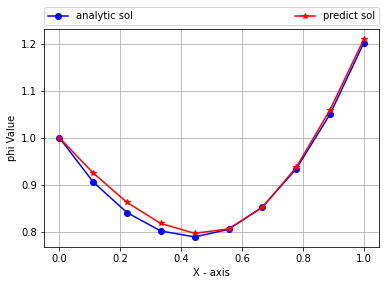

In [220]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots()

ax.plot(t_all, phi_analytic, 'bo-', label="analytic sol") 
ax.plot(t_all, phi_predict, 'r*-', label="predict sol")

ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)

ax.set_ylabel('phi Value')
ax.set_xlabel('X - axis')
ax.grid()
plt.savefig('ANN_for_ODE.png')
plt.show()